# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

C:\Users\creva\AppData\Local\Temp\ipykernel_22048\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

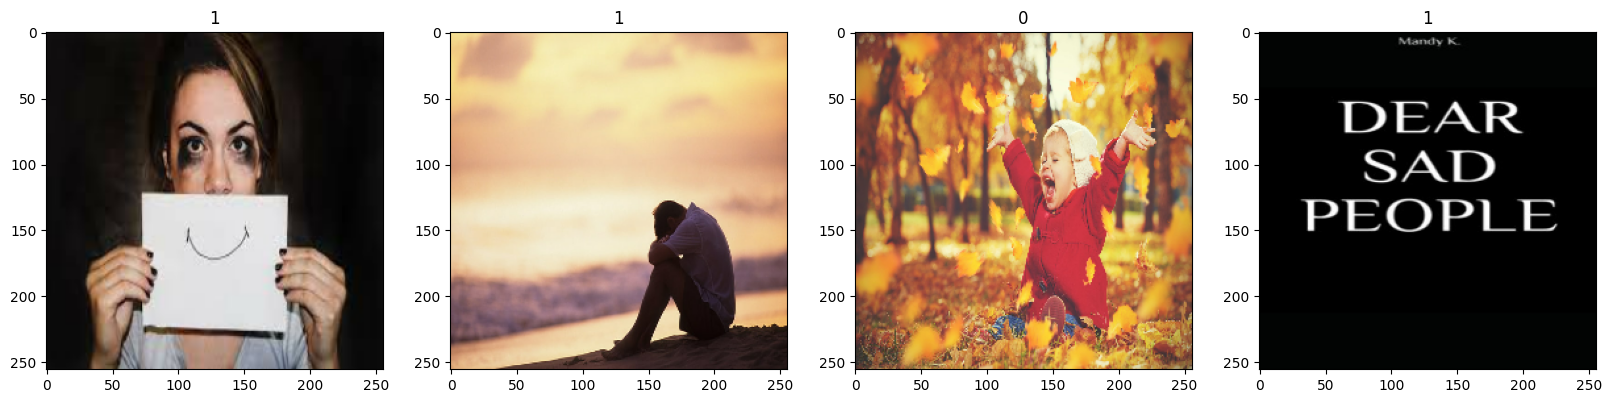

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.14901961, 0.14901961, 0.14901961],
          [0.14800858, 0.14800858, 0.14800858],
          [0.14341299, 0.14341299, 0.14341299],
          ...,
          [0.50811887, 0.50811887, 0.50811887],
          [0.51271445, 0.51271445, 0.51271445],
          [0.5137255 , 0.5137255 , 0.5137255 ]],
 
         [[0.14935662, 0.14935662, 0.14935662],
          [0.14834559, 0.14834559, 0.14834559],
          [0.14375   , 0.14375   , 0.14375   ],
          ...,
          [0.5089377 , 0.5089377 , 0.5089377 ],
          [0.51313835, 0.51313835, 0.51313835],
          [0.5140625 , 0.5140625 , 0.5140625 ]],
 
         [[0.15088849, 0.15088849, 0.15088849],
          [0.14987744, 0.14987744, 0.14987744],
          [0.14528187, 0.14528187, 0.14528187],
          ...,
          [0.51265967, 0.51265967, 0.51265967],
          [0.51506513, 0.51506513, 0.51506513],
          [0.51559436, 0.51559436, 0.51559436]],
 
         ...,
 
         [[0.46629903, 0.46629903, 0.46629903],
          [0.46013

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\creva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 701ms/step - accuracy: 0.5849 - loss: 1.0538 - val_accuracy: 0.5625 - val_loss: 0.7192
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - accuracy: 0.5503 - loss: 0.7076 - val_accuracy: 0.5781 - val_loss: 0.6670
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 542ms/step - accuracy: 0.6375 - loss: 0.6577 - val_accuracy: 0.4531 - val_loss: 0.6836
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.5729 - loss: 0.6108 - val_accuracy: 0.8438 - val_loss: 0.5863
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.7225 - loss: 0.5719 - val_accuracy: 0.8125 - val_loss: 0.4506
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.8251 - loss: 0.4334 - val_accuracy: 0.8125 - val_loss: 0.3564
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - accuracy: 0.8913 - loss: 0.3261 - val_accuracy: 0.8906 - val_loss: 0.2524
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - accuracy: 0.8972 - loss: 0.2976 - val_accuracy: 0.9062 - val_loss

In [27]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

In [28]:
print(f"Final Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")

Final Training Accuracy: 98.66%
Final Validation Accuracy: 100.00%


# 8. Plot Performance

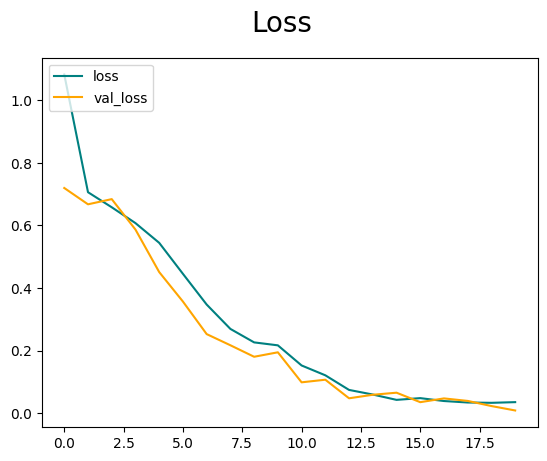

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

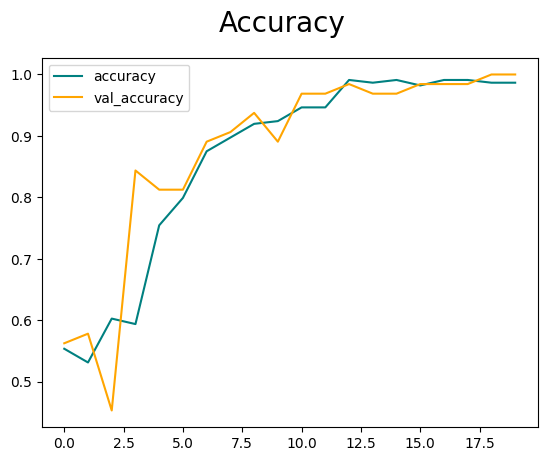

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2
import pyttsx3
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

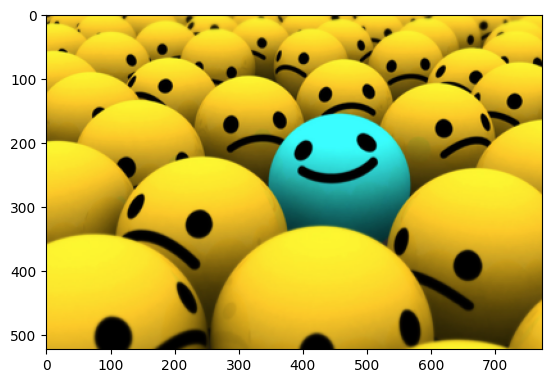

In [36]:
img = cv2.imread('data/happy/Screen-Shot-2012-10-23-at-12.57.22-PM.png')
plt.imshow(img)
plt.show()

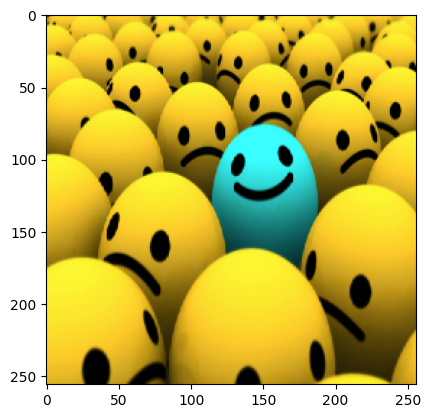

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
engine = pyttsx3.init()

In [39]:
img = cv2.imread('154006829.jpg')
resize = tf.image.resize(img, (256, 256))

In [40]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


In [41]:
if yhat > 0.5:
    text_output = 'Predicted class is Sad'
else:
    text_output = 'Predicted class is Happy'

In [49]:
print(text_output)

Predicted class is Happy


In [43]:
engine.say(text_output)
engine.runAndWait()

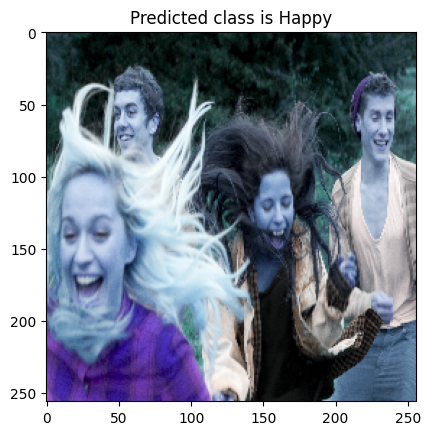

In [44]:
plt.imshow(resize.numpy().astype(int))
plt.title(text_output)
plt.show()


# 11. Save the Model

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model.save(os.path.join('models','imageclassifier.h5'))

In [47]:
new_model = load_model("imageclassifier.h5",compile=False)

In [48]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


array([[0.01972743]], dtype=float32)